In [1]:
import openmc
import numpy as np

In [2]:
# Create materials
fuel = openmc.Material(name='fuel')
fuel.set_density('g/cm3', density=3.35)
fuel.add_components({'Li7': 0.0787474673879085,
                  'Be9': 0.0225566879138321,
                  'F19': 0.454003012179284,
                  'Th232': 0.435579130482336,
                  'U233': 0.00911370203663893},
                 percent_type='wo')
fuel.depletable = True
fuel.volume = 48710000.0

moder = openmc.Material(name='graphite', temperature=900.0)
moder.set_density('g/cm3', density=1.84)
moder.add_nuclide('C0', 1.000, percent_type='wo')
moder.add_s_alpha_beta('c_Graphite')

hast = openmc.Material(name='hastelloyN', temperature=900.0)
hast.set_density('g/cm3', density=8.671)
hast.add_components({'Al27': 0.003,
                  'Ni': 0.677,
                  'W': 0.250,
                  'Cr': 0.070},
                 percent_type='wo')

mat = openmc.Materials(materials=[fuel, moder, hast])
mat.export_to_xml()

In [3]:
colormap = {moder: 'purple',
            hast: 'blue',
            fuel: 'yellow'}

In [4]:
 def _bound_zone_cells(cells_tuples, levels):
    """Helper function that moves Zone IA and Zone IIA cells to the
    appropriate height."""
    cell_list = []
    n_levels = len(cells_tuples)
    print(f'{n_levels}')
    for i, cells in enumerate(cells_tuples):
        if i == 0:
            lower_bound = None
            upper_bound = levels[i]
        elif i == n_levels - 1:
            lower_bound = levels[i-1]
            upper_bound = None
        else:
            lower_bound = levels[i-1]
            upper_bound = levels[i]
        for j, cell in enumerate(cells):
            if lower_bound is None:
                cell.region = cell.region & -upper_bound
            elif upper_bound is None:
                cell.region = cell.region & +lower_bound
            else:
                cell.region = cell.region & +lower_bound & -upper_bound
            cell_list.append(cell)
    return cell_list

def shared_elem_geometry():
    """Surfaces and regions shared by Zone IA and Zone IIA elements. 
    Specs found in Robertson, 1971 Fig 3.4 (p. 17) and Fig 3.5 (p.18)"""

    elem_bound = openmc.rectangular_prism(5.08*2, 5.08*2) # Pin outer boundary
    eb_minx, eb_maxx, eb_miny, eb_maxy = list(elem_bound.get_surfaces().values())

    gr_sq_neg = openmc.rectangular_prism(4.953*2, 4.953*2, corner_radius=0.46) # Graphite square
    (gr_minx, gr_maxx, gr_miny, gr_maxy, 
    gr_cyl_lb, gr_cyl_minx, gr_cyl_miny, 
    gr_cyl_ul, gr_cyl_maxy, gr_cyl_br, 
    gr_cyl_maxx, gr_cyl_ru) = list(gr_sq_neg.get_surfaces().values())

    # params for main pin section for both I-A and II-A
    r_d = 0.66802
    l1 = 4.28498
    l2 = 4.53898
    l3 = 5.62102
    ul = openmc.ZCylinder(-l1, l2, r_d, name='corner_ul')
    br = openmc.ZCylinder(l1, -l2, r_d, name='corner_br')
    lb = openmc.ZCylinder(-l2, -l1, r_d, name='corner_lb')
    ru = openmc.ZCylinder(l2, l1, r_d, name='corner_ru')
    ul_t = openmc.ZCylinder(-l1, -l3, r_d, name='corner_ul_tip')
    br_t = openmc.ZCylinder(l1, l3, r_d, name='corner_br_tip')
    ru_t = openmc.ZCylinder(-l3, l1, r_d, name='corner_ru_tip')
    lb_t = openmc.ZCylinder(l3, -l1, r_d, name='corner_lb_tip')

    #gr_corners = elem_bound & (-ul | -br | -lb | -ru)
    
    gr_ul = -ul & -eb_maxy & +gr_maxy# | 
    gr_ul_fill = -ul & +gr_cyl_ul & -gr_maxy & -gr_cyl_minx & +gr_cyl_maxy
    gr_br = -br & +eb_miny & -gr_miny# | 
    gr_br_fill = -br & +gr_cyl_br & +gr_miny & +gr_cyl_maxx & -gr_cyl_miny 
    gr_lb = -lb & +eb_minx & -gr_minx# | 
    gr_lb_fill = -lb & +gr_cyl_lb & +gr_minx & -gr_cyl_minx & -gr_cyl_miny 
    gr_ru = -ru & -eb_maxx & +gr_maxx# | 
    gr_ru_fill = -ru & +gr_cyl_ru & -gr_maxx & +gr_cyl_maxx & +gr_cyl_maxy

    
    gr_ul_t = -ul_t & +eb_miny & -gr_miny
    gr_br_t = -br_t & -eb_maxy & +gr_maxy
    gr_ru_t = -ru_t & +eb_minx & -gr_minx
    gr_lb_t = -lb_t & -eb_maxx & +gr_maxx 
 
    gr_corners = (gr_ul, gr_br, gr_lb, gr_ru, gr_ul_fill, gr_br_fill, gr_lb_fill, gr_ru_fill)
    gr_t = (gr_ul_t, gr_br_t, gr_ru_t, gr_lb_t)

    inter_elem_channel = (~gr_sq_neg & elem_bound &
                          +ul & +br & +lb & +ru &
                          +ul_t & +br_t & +ru_t & +lb_t)
    
    gr_round_4 = openmc.ZCylinder(r=2.2225, name='gr_round_4')

    
    return elem_bound, gr_sq_neg, gr_corners, gr_t, inter_elem_channel, gr_round_4
                        

In [5]:
def zoneIA(elem_bound, gr_sq_neg, gr_corners, gr_t, inter_elem_channel, gr_round_4):
    """Zone IA element. Specs found in Robertson, 1971 Fig 3.4 (p. 17)"""
    elem_levels = [22.86, 419.10, 438.15, 445.135]
    level_bounds = []
    for level in elem_levels:
        level_bounds.append(openmc.ZPlane(z0=level))
    s1 = openmc.ZCylinder(r=4.953, name='ia_gr_round_1')
    s2 = openmc.ZCylinder(r=1.71069, name='ia_fuel_hole')
    
    h = 12.66
    theta = np.arctan(4.953 / h)
    r2 = (1 / np.cos(theta))**2 - 1
    s3 = openmc.ZCone(z0=h + elem_levels[2], r2=r2, name='cone_i')

    c1 = openmc.Cell(fill=fuel, region=(-s2), name='ia_fuel_inner_1')
    c2 = openmc.Cell(fill=moder, region=(+s2 & -s1), name='ia_moderator_1')
    c3 = openmc.Cell(fill=fuel, region=(+s1 & elem_bound), name='ia_fuel_outer_1')
    ia1 = (c1, c2, c3)
                         
    # I-A  main (lower 2)
    s2 = s2.clone()
    gr_sq_neg = gr_sq_neg.clone()
    c4 = c1.clone(clone_materials=False)
    c4.name = 'ia_fuel_inner_main'
    c5 = openmc.Cell(fill=moder, region=(+s2 & gr_sq_neg), name='ia_moderator_main')
    c6 = openmc.Cell(fill=fuel, region=(inter_elem_channel), name='ia_fuel_outer_main')
    c5_ul = openmc.Cell(fill=moder, region=gr_corners[0], name='ia_moderator_main_ul')
    c5_br = openmc.Cell(fill=moder, region=gr_corners[1], name='ia_moderator_main_br')
    c5_ru = openmc.Cell(fill=moder, region=gr_corners[2], name='ia_moderator_main_ru')
    c5_lb = openmc.Cell(fill=moder, region=gr_corners[3], name='ia_moderator_main_lb')
    c5_ulf = openmc.Cell(fill=moder, region=gr_corners[4], name='ia_moderator_main_ul_fill')
    c5_brf = openmc.Cell(fill=moder, region=gr_corners[5], name='ia_moderator_main_br_fill')
    c5_ruf = openmc.Cell(fill=moder, region=gr_corners[6], name='ia_moderator_main_ru_fill')
    c5_lbf = openmc.Cell(fill=moder, region=gr_corners[7], name='ia_moderator_main_lb_fill')
    c5_ul_t = openmc.Cell(fill=moder, region=gr_t[0], name='ia_moderator_main_ul_t')
    c5_br_t = openmc.Cell(fill=moder, region=gr_t[1], name='ia_moderator_main_br_t')
    c5_ru_t = openmc.Cell(fill=moder, region=gr_t[2], name='ia_moderator_main_ru_t')
    c5_lb_t = openmc.Cell(fill=moder, region=gr_t[3], name='ia_moderator_main_lb_t')
 
    iam = (c4, c5, c6, c5_ul, c5_br, c5_ru, c5_lb, c5_ulf, c5_brf, c5_ruf, c5_lbf, c5_ul_t, c5_br_t, c5_ru_t, c5_lb_t)
                         
    # I-A 2 (upper 1)
    c7 = c1.clone(clone_materials=False)
    c7.name = 'ia_fuel_inner_2'
    c8 = c2.clone(clone_materials=False)
    c8.name = 'ia_moderator_2'
    c9 = c3.clone(clone_materials=False)
    c9.name = 'ia_fuel_outer_2'
    ia2 = (c7, c8, c9)

    # I-A 3 (upper 2)'
    s2 = s2.clone()
    s3 = s3.clone()
    elem_bound = elem_bound.clone()
    c10 = c1.clone(clone_materials=False)
    c10.name = 'ia_fuel_inner_3'
    c11 = openmc.Cell(fill=moder, region=(+s2 & -s3), name='ia_moderator_3')
    c12 = openmc.Cell(fill=fuel, region=(+s3 & elem_bound), name='ia_fuel_outer_3')
    ia3 = (c10, c11, c12)                             
                         
    # I-A 4 (upper 3)
    s2 = s2.clone()
    elem_bound = elem_bound.clone()
    c13 = openmc.Cell(fill=hast, region=(-s2), name='ia_hast')
    c14 = openmc.Cell(fill=moder, region=(+s2 & -gr_round_4), name='ia_moderator_4')
    c15 = openmc.Cell(fill=fuel, region=(+gr_round_4 & elem_bound), name='ia_fuel_outer_4')
    ia4 = (c13, c14, c15)
    
    elem_cells = [ia1, iam, ia2, ia3, ia4]
    # universe_id=1
    ia = openmc.Universe(name='zone_ia')
    ia.add_cells(_bound_zone_cells(elem_cells, level_bounds))
                 
    return ia

def zoneIIA(elem_bound, gr_sq_neg, gr_corners, gr_t, inter_elem_channel, gr_round_4):
    """Zone IIA element. Specs found in Robertson, 1971 Fig 3.5 (p. 18)"""
    elem_levels = [434.34, 436.88, 439.42, 441.96]
    level_bounds = []
    for level in elem_levels:
        level_bounds.append(openmc.ZPlane(z0=level))
    s1 = openmc.ZCylinder(r=3.302, name='iia_fuel_hole_main') # Hole with fuel salt - Fig 3.5, Roberton 1971 (3.27787 - p.47)
    s2 = openmc.ZCylinder(r=0.635, name='iia_fuel_hole_2')
    s3 = openmc.ZCylinder(r=3.65125, name='iia_gr_round_3')
    h = 6.5
    theta = np.arctan(3.65125 / h)
    r2 = (1 / np.cos(theta))**2 - 1
    s4 = openmc.ZCone(z0=h + elem_levels[2], r2=r2, name='cone_ii')

    # II-A main (lower 1)
    c1 = openmc.Cell(fill=fuel, region=(-s1), name='iia_fuel_inner_main')
    c2 = openmc.Cell(fill=moder, region=(+s1 & gr_sq_neg), name='iia_moderator_main')
    c3 = openmc.Cell(fill=fuel, region=(inter_elem_channel), name='iia_fuel_outer_main')
    c3.name = 'iia_fuel_outer_main'
    c2_ul = openmc.Cell(fill=moder, region=gr_corners[0], name='iia_moderator_main_ul')
    c2_br = openmc.Cell(fill=moder, region=gr_corners[1], name='iia_moderator_main_br')
    c2_ru = openmc.Cell(fill=moder, region=gr_corners[2], name='iia_moderator_main_ru')
    c2_lb = openmc.Cell(fill=moder, region=gr_corners[3], name='iia_moderator_main_lb')
    c2_ulf = openmc.Cell(fill=moder, region=gr_corners[4], name='iia_moderator_main_ul_fill')
    c2_brf = openmc.Cell(fill=moder, region=gr_corners[5], name='iia_moderator_main_br_fill')
    c2_ruf = openmc.Cell(fill=moder, region=gr_corners[6], name='iia_moderator_main_ru_fill')
    c2_lbf = openmc.Cell(fill=moder, region=gr_corners[7], name='iia_moderator_main_lb_fill')
    c2_ul_t = openmc.Cell(fill=moder, region=gr_t[0], name='iia_moderator_main_ul_t')
    c2_br_t = openmc.Cell(fill=moder, region=gr_t[1], name='iia_moderator_main_br_t')
    c2_ru_t = openmc.Cell(fill=moder, region=gr_t[2], name='iia_moderator_main_ru_t')
    c2_lb_t = openmc.Cell(fill=moder, region=gr_t[3], name='iia_moderator_main_lb_t')
    iiam = (c1, c2, c3, c2_ul, c2_br, c2_ru, c2_lb, c2_ulf, c2_brf, c2_ruf, c2_lbf, c2_ul_t, c2_br_t, c2_ru_t, c2_lb_t)

    # II-A 2 (upper 1)
    gr_sq_neg = gr_sq_neg.clone()
    c4 = openmc.Cell(fill=fuel, region=(-s2), name='iia_fuel_inner_2')
    c5 = openmc.Cell(fill=moder, region=(+s2 & gr_sq_neg), name='iia_moderator_2')
    c6 = c3.clone(clone_materials=False)
    c6.name = 'iia_fuel_outer_2'
    c5_ul = openmc.Cell(fill=moder, region=gr_corners[0], name='iia_moderator_2_ul')
    c5_br = openmc.Cell(fill=moder, region=gr_corners[1], name='iia_moderator_2_br')
    c5_ru = openmc.Cell(fill=moder, region=gr_corners[2], name='iia_moderator_2_ru')
    c5_lb = openmc.Cell(fill=moder, region=gr_corners[3], name='iia_moderator_2_lb')
    c5_ulf = openmc.Cell(fill=moder, region=gr_corners[4], name='iia_moderator_2_ul_fill')
    c5_brf = openmc.Cell(fill=moder, region=gr_corners[5], name='iia_moderator_2_br_fill')
    c5_ruf = openmc.Cell(fill=moder, region=gr_corners[6], name='iia_moderator_2_ru_fill')
    c5_lbf = openmc.Cell(fill=moder, region=gr_corners[7], name='iia_moderator_2_lb_fill')
    c5_ul_t = openmc.Cell(fill=moder, region=gr_t[0], name='iia_moderator_2_ul_t')
    c5_br_t = openmc.Cell(fill=moder, region=gr_t[1], name='iia_moderator_2_br_t')
    c5_ru_t = openmc.Cell(fill=moder, region=gr_t[2], name='iia_moderator_2_ru_t')
    c5_lb_t = openmc.Cell(fill=moder, region=gr_t[3], name='iia_moderator_2_lb_t')
    iia2 = (c4, c5, c6, c5_ul, c5_br, c5_ru, c5_lb, c5_ulf, c5_brf, c5_ruf, c5_lbf, c5_ul_t, c5_br_t, c5_ru_t, c5_lb_t)

    # II-A 3 (upper 2)
    s2 = s2.clone()
    elem_bound = elem_bound.clone()
    c7 = c4.clone(clone_materials=False)
    c7.name = 'iia_fuel_inner_3'
    c8 = openmc.Cell(fill=moder, region=(+s2 & -s3), name='iia_moderator_3')
    c9 = openmc.Cell(fill=fuel, region=(+s3 & elem_bound), name='iia_fuel_outer_3')
    iia3 = (c7, c8, c9)

    # II-A 4 (upper 3)  
    elem_bound = elem_bound.clone()
    c10 = openmc.Cell(fill=moder, region=(-s4), name='iia_moderator_4')
    c11 = openmc.Cell(fill=fuel, region=(+s4 & elem_bound), name='iia_fuel_outer_4')
    iia4 = (c10, c11)

    # II-A 5 (upper 4)
    elem_bound = elem_bound.clone()
    c12 = openmc.Cell(fill=moder, region=(-gr_round_4), name='iia_moderator_5')
    c13 = openmc.Cell(fill=fuel, region=(+gr_round_4 & elem_bound), name='iia_fuel_outer_5')
    iia5 = (c12, c13)
    
    elem_cells = [iiam, iia2, iia3, iia4, iia5]
    # universe_id=2
    iia = openmc.Universe(name='zone_iia')
    iia.add_cells(_bound_zone_cells(elem_cells, level_bounds))
    return iia

def void_cell(elem_bound):
    elem_bound = elem_bound.clone()
    c1 = openmc.Cell(region=elem_bound, name='lattice_void')
    #universe_id=5
    v = openmc.Universe(name='lattice_void')
    v.add_cell(c1)
    return v

def graphite_triangles(elem_bound):
    s1 = openmc.Plane(1.0, 1.0, 0.0, 0.0)
    s2 = openmc.Plane(-1.0, 1.0, 0.0, 0.0)
    s3 = openmc.Plane(1.0, -1.0, 0.0, 0.0)
    s4 = openmc.Plane(-1.0, -1.0, 0.0, 0.0)
    
    surfs = [(s4, 'bottom_left'),
             (s1, 'top_right'),
             (s2, 'top_left'),
             (s3, 'bottom_right')]
    univs = []
    for i, (s, name) in enumerate(surfs):
        elem_bound = elem_bound.clone()
        c1 = openmc.Cell(fill=moder, region=(-s & elem_bound))
        elem_bound = elem_bound.clone()
        c2 = openmc.Cell(fill=fuel, region=(+s & elem_bound))
    
        # universe_id = 6+i
        gr_tri = openmc.Universe(name=f'{name}_triangle')
        gr_tri.add_cells([c1, c2])
        univs.append(gr_tri)
    
    return univs

In [6]:
elem_bound, gr_sq_neg, gr_corners, gr_t, inter_elem_channel, gr_round_4 = shared_elem_geometry()
ia = zoneIA(elem_bound, gr_sq_neg, gr_corners, gr_t, inter_elem_channel, gr_round_4)
elem_bound, gr_sq_neg, gr_corners, gr_t, inter_elem_channel, gr_round_4 = shared_elem_geometry()
iia = zoneIIA(elem_bound, gr_sq_neg, gr_corners, gr_t, inter_elem_channel, gr_round_4)
# tres, uno, dos, quatro
bl, ur, ul, br = graphite_triangles(elem_bound)

5
5


In [23]:
ia.get_all_cells()

OrderedDict([(1,
              Cell
              	ID             =	1
              	Name           =	ia_fuel_inner_1
              	Fill           =	Material 1
              	Region         =	(-32 -27)
              	Rotation       =	None
              	Temperature    =	None
              	Translation    =	None
              	Volume         =	None),
             (2,
              Cell
              	ID             =	2
              	Name           =	ia_moderator_1
              	Fill           =	Material 2
              	Region         =	(32 -31 -27)
              	Rotation       =	None
              	Temperature    =	None
              	Translation    =	None
              	Volume         =	None),
             (3,
              Cell
              	ID             =	3
              	Name           =	ia_fuel_outer_1
              	Fill           =	Material 1
              	Region         =	(31 1 -2 3 -4 -27)
              	Rotation       =	None
              	Temperature    =	None
      

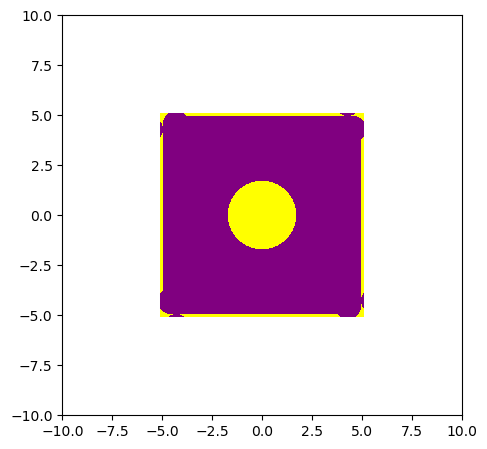

In [7]:
ia.plot(width=(20,20),
        basis='xy',
        colors=colormap,
        origin=(0.,0.,150),
        color_by='material',
        pixels=(400,400))

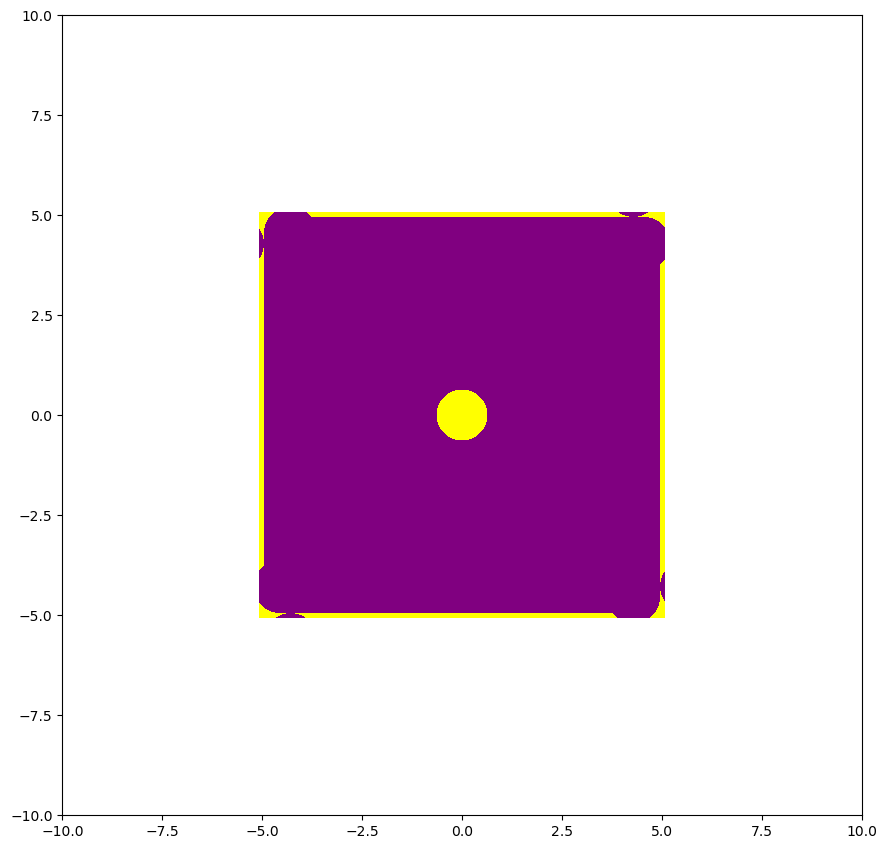

In [8]:
iia.plot(width=(20,20),
        basis='xy',
        colors=colormap,
        origin=(0.,0.,435),
        color_by='material',
        pixels=(800,800))

In [9]:
def shared_cr_geometry():
    fuel_hole = openmc.ZCylinder(r=5.08, name='cr_fuel_hole')
    
    elem_bound = openmc.rectangular_prism(7.62*2, 7.62*2) # Pin outer boundary
    eb_minx, eb_maxx, eb_miny, eb_maxy = list(elem_bound.get_surfaces().values())
    
    gr_sq_neg = openmc.rectangular_prism(7.23646*2, 7.23646*2, corner_radius=0.99) # Graphite square
    # params for 
    (gr_minx, gr_maxx, gr_miny, gr_maxy, 
    gr_cyl_lb, gr_cyl_minx, gr_cyl_miny, 
    gr_cyl_ul, gr_cyl_maxy, gr_cyl_br, 
    gr_cyl_maxx, gr_cyl_ru) = list(gr_sq_neg.get_surfaces().values())
    
    r_d = 1.16
    e_d = 2 * r_d / np.sqrt(3)
    r_dt = 0.8
    r_c = 0.18
    l1 = 5.8801
    l2 = 6.505
    l3 = 8.03646
    ul = openmc.model.hexagonal_prism(origin=(-l1, l2), edge_length=e_d, orientation='x', corner_radius=r_c)
    br = openmc.model.hexagonal_prism(origin=(l1, -l2), edge_length=e_d, orientation='x',corner_radius=r_c)
    lb = openmc.model.hexagonal_prism(origin=(-l2, -l1), edge_length=e_d, orientation='y',corner_radius=r_c)
    ru = openmc.model.hexagonal_prism(origin=(l2, l1), edge_length=e_d, orientation='y',corner_radius=r_c)
    ul_t = openmc.ZCylinder(-l1, -l3, r_dt, name='corner_ul_tip')
    br_t = openmc.ZCylinder(l1, l3, r_dt, name='corner_br_tip')
    ru_t = openmc.ZCylinder(-l3, l1, r_dt, name='corner_ru_tip')
    lb_t = openmc.ZCylinder(l3, -l1, r_dt, name='corner_lb_tip')
    
    gr_ul = ul & -eb_maxy & +gr_maxy# | 
    gr_ul_fill = ul & +gr_cyl_ul & -gr_maxy & -gr_cyl_minx & +gr_cyl_maxy
    gr_br = br & +eb_miny & -gr_miny# | 
    gr_br_fill = br & +gr_cyl_br & +gr_miny & +gr_cyl_maxx & -gr_cyl_miny 
    gr_lb = lb & +eb_minx & -gr_minx# | 
    gr_lb_fill = lb & +gr_cyl_lb & +gr_minx & -gr_cyl_minx & -gr_cyl_miny 
    gr_ru = ru & -eb_maxx & +gr_maxx# | 
    gr_ru_fill = ru & +gr_cyl_ru & -gr_maxx & +gr_cyl_maxx & +gr_cyl_maxy

    
    gr_ul_t = -ul_t & +eb_miny & -gr_miny
    gr_br_t = -br_t & -eb_maxy & +gr_maxy
    gr_ru_t = -ru_t & +eb_minx & -gr_minx
    gr_lb_t = -lb_t & -eb_maxx & +gr_maxx 
 
    gr_corners = (gr_ul, gr_br, gr_lb, gr_ru, gr_ul_fill, gr_br_fill, gr_lb_fill, gr_ru_fill)
    gr_t = (gr_ul_t, gr_br_t, gr_ru_t, gr_lb_t)

    inter_elem_channel = (~gr_sq_neg & elem_bound &
                         ~ul & ~br & ~lb & ~ru &
                         +ul_t & +br_t & +ru_t & +lb_t)
    


    return fuel_hole, gr_sq_neg, gr_corners, gr_t, inter_elem_channel
              

In [10]:
def control_rod(fuel_hole, gr_sq_neg, gr_corners, gr_t, inter_elem_channel):
    s1 = openmc.ZCylinder(r=4.7625, name='control_rod')

    c1 = openmc.Cell(fill=moder, region=-s1, name='control_rod')
    c2 = openmc.Cell(fill=fuel, region=(+s1 & -fuel_hole), name='cr_fuel_inner')
    
    c3 = openmc.Cell(fill=moder, region=(+fuel_hole & gr_sq_neg), name='cr_moderator')
    c4 = openmc.Cell(fill=fuel, region=inter_elem_channel, name='cr_fuel_outer')
    
    c3_ul = openmc.Cell(fill=moder, region=gr_corners[0], name='cr_moderator_ul')
    c3_br = openmc.Cell(fill=moder, region=gr_corners[1], name='cr_moderator_br')
    c3_ru = openmc.Cell(fill=moder, region=gr_corners[2], name='cr_moderator_ru')
    c3_lb = openmc.Cell(fill=moder, region=gr_corners[3], name='cr_moderator_lb')
    c3_ulf = openmc.Cell(fill=moder, region=gr_corners[4], name='cr_moderator_ul_fill')
    c3_brf = openmc.Cell(fill=moder, region=gr_corners[5], name='cr_moderator_br_fill')
    c3_ruf = openmc.Cell(fill=moder, region=gr_corners[6], name='cr_moderator_ru_fill')
    c3_lbf = openmc.Cell(fill=moder, region=gr_corners[7], name='cr_moderator_lb_fill')
    c3_ul_t = openmc.Cell(fill=moder, region=gr_t[0], name='cr_moderator_ul_t')
    c3_br_t = openmc.Cell(fill=moder, region=gr_t[1], name='cr_moderator_br_t')
    c3_ru_t = openmc.Cell(fill=moder, region=gr_t[2], name='cr_moderator_ru_t')
    c3_lb_t = openmc.Cell(fill=moder, region=gr_t[3], name='cr_moderator_lb_t')

    #universe_id=3
    cr = openmc.Universe(name='control_rod')
    cr.add_cells([c1, c2, c3, c4, c3_ul, c3_br, c3_ru, c3_lb, c3_ulf, c3_brf, c3_ruf, c3_lbf, c3_ul_t, c3_br_t, c3_ru_t, c3_lb_t])
    
    return cr
    
def control_rod_channel(fuel_hole, gr_sq_neg, gr_corners, gr_t, inter_elem_channel):
    c1 = openmc.Cell(fill=fuel, region=(-fuel_hole), name='crc_fuel_inner')
    c2 = openmc.Cell(fill=moder, region=(+fuel_hole & gr_sq_neg), name='crc_moderator')
    c3 = openmc.Cell(fill=fuel, region=inter_elem_channel, name='crc_fuel_outer')
    
    c2_ul = openmc.Cell(fill=moder, region=gr_corners[0], name='crc_moderator_ul')
    c2_br = openmc.Cell(fill=moder, region=gr_corners[1], name='crc_moderator_br')
    c2_ru = openmc.Cell(fill=moder, region=gr_corners[2], name='crc_moderator_ru')
    c2_lb = openmc.Cell(fill=moder, region=gr_corners[3], name='crc_moderator_lb')
    c2_ulf = openmc.Cell(fill=moder, region=gr_corners[4], name='crc_moderator_ul_fill')
    c2_brf = openmc.Cell(fill=moder, region=gr_corners[5], name='crc_moderator_br_fill')
    c2_ruf = openmc.Cell(fill=moder, region=gr_corners[6], name='crc_moderator_ru_fill')
    c2_lbf = openmc.Cell(fill=moder, region=gr_corners[7], name='crc_moderator_lb_fill')
    c2_ul_t = openmc.Cell(fill=moder, region=gr_t[0], name='crc_moderator_ul_t')
    c2_br_t = openmc.Cell(fill=moder, region=gr_t[1], name='crc_moderator_br_t')
    c2_ru_t = openmc.Cell(fill=moder, region=gr_t[2], name='crc_moderator_ru_t')
    c2_lb_t = openmc.Cell(fill=moder, region=gr_t[3], name='crc_moderator_lb_t')

    # universe_id=4
    crc = openmc.Universe(name='control_rod_channel')
    crc.add_cells([c1, c2, c3, c2_ul, c2_br, c2_ru, c2_lb, c2_ulf, c2_brf, c2_ruf, c2_lbf, c2_ul_t, c2_br_t, c2_ru_t, c2_lb_t])
    
    return crc

In [11]:
fuel_hole, gr_sq_neg, gr_corners, gr_t, inter_elem_channel = shared_cr_geometry()          

In [12]:
openmc.Cell(region=gr_corners[0])

Cell
	ID             =	73
	Name           =	
	Fill           =	None
	Region         =	(-206 207 -208 209 210 -211 ~((212 -218) | (213 -219) | (214 -220) | (215 -221) | (216 -222) | (217 -223)) -192 196)
	Rotation       =	None
	Translation    =	None
	Volume         =	None

In [13]:
fuel_hole, gr_sq_neg, gr_corners, gr_t, inter_elem_channel = shared_cr_geometry()          
cr = control_rod(fuel_hole, gr_sq_neg, gr_corners, gr_t, inter_elem_channel)
fuel_hole, gr_sq_neg, gr_corners, gr_t, inter_elem_channel = shared_cr_geometry()          
crc = control_rod_channel(fuel_hole, gr_sq_neg, gr_corners, gr_t, inter_elem_channel)

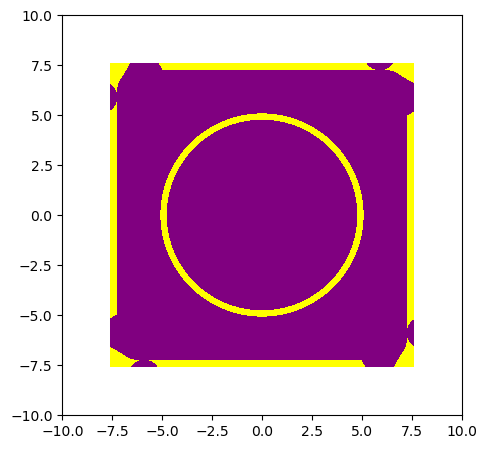

In [14]:
cr.plot(width=(20,20),
        basis='xy',
        colors=colormap,
        origin=(0.,0.,440),
        color_by='material',
        pixels=(400,400))

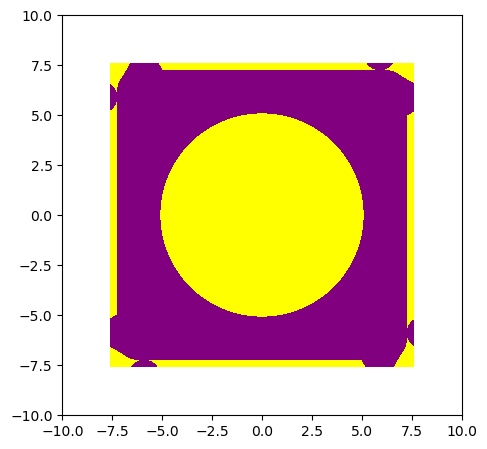

In [15]:
crc.plot(width=(20,20),
        basis='xy',
        colors=colormap,
        origin=(0.,0.,440),
        color_by='material',
        pixels=(400,400))

In [16]:
def shared_root_geometry():
    cr_boundary = openmc.model.rectangular_prism(15.24*2, 15.24*2)
    
    core_base = openmc.ZPlane(z0=0.0, name='core_base')
    core_top = openmc.ZPlane(z0=449.58, name='core_top')
    
    s1 = openmc.model.IsogonalOctagon(center=(0.0,0.0), r1=208.28, r2=222.71, name='base_octader')
    s2 = openmc.model.IsogonalOctagon(center=(0.0,0.0), r1=218.44, r2=215.53, name='smaller_octader')
    s3 = openmc.model.IsogonalOctagon(center=(0.0,0.0), r1=228.60, r2=193.97, name='smallest_octader')
    zone_i_boundary = -s1 | -s2 | -s3

    zone_ii_boundary = openmc.ZCylinder(r=256.032, name='iib_boundary')
    annulus_boundary = openmc.ZCylinder(r=261.112, name='annulus_boundary')
    lower_plenum_boundary = openmc.ZPlane(z0=-7.62, name='lower_plenum_boundary')

    zone_bounds = (cr_boundary, zone_i_boundary, zone_ii_boundary)
    
    core_bounds = (annulus_boundary, lower_plenum_boundary, core_base, core_top)
    
    radial_reflector_boundary = openmc.ZCylinder(r=338.328, name='radial_reflector_boundary')    
    bottom_reflector_boundary = openmc.ZPlane(z0=-76.2, name='bottom_axial_reflector_boundary')
    top_reflector_boundary = openmc.ZPlane(z0=525.78, name='top_axial_reflector_boundary') 
    
    reflector_bounds = (radial_reflector_boundary,
                        bottom_reflector_boundary,
                        top_reflector_boundary)
    
    radial_vessel_boundary = openmc.ZCylinder(r=343.408, name='radial_vessel_wall', boundary_type='vacuum')
    bottom_vessel_boundary = openmc.ZPlane(z0=-81.28, name='bottom_vessel_wall', boundary_type='vacuum')
    top_vessel_boundary = openmc.ZPlane(z0=530.86, name='top_vessel_wall', boundary_type='vacuum')
    
    vessel_bounds = (radial_vessel_boundary,
                     bottom_vessel_boundary,
                     top_vessel_boundary)
    
    return zone_bounds, core_bounds, reflector_bounds, vessel_bounds

def cr_lattice(cr_boundary, core_base, core_top):
    fuel_hole, gr_sq_neg, gr_corners, gr_t, inter_elem_channel = shared_cr_geometry()          
    elem_bound = openmc.rectangular_prism(7.62*2, 7.62*2) # Pin outer boundary

    f = control_rod(fuel_hole, gr_sq_neg, gr_corners, gr_t, inter_elem_channel)
    e = control_rod_channel(fuel_hole, gr_sq_neg, gr_corners, gr_t, inter_elem_channel)
    
    cr = openmc.RectLattice()
    cr.pitch = np.array([15.24, 15.24])
    N = 2 / 2
    cr.lower_left = -1 * cr.pitch * N
    cr.universes = [[f, e],
                    [e, f]]
    
    c1 = openmc.Cell(fill=cr, region=(+core_base & -core_top & cr_boundary), name='cr_lattice')
    
    return c1

def main_lattice(zone_i_boundary, cr_boundary, core_base, core_top):
    elem_bound, gr_sq_neg, gr_corners, gr_t, inter_elem_channel, gr_round_4 = shared_elem_geometry()
    l = zoneIA(elem_bound, gr_sq_neg, gr_corners, gr_t, inter_elem_channel, gr_round_4)
    z = zoneIIA(elem_bound, gr_sq_neg, gr_corners, gr_t, inter_elem_channel, gr_round_4)
    v = void_cell(elem_bound)
    # tres, uno, dos, quatro
    t, u, d, q = graphite_triangles(elem_bound) 
    
    main = openmc.RectLattice()
    main.pitch = np.array([10.16, 10.16])
    N = 45 / 2
    main.lower_left = -1 * main.pitch * N
    main.universes = [[v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, d, z, z, z, z, z, z, z, z, z, u, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, v, v, v, v, d, z, z, z, z, l, l, l, l, l, l, l, l, l, z, z, z, z, u, v, v, v, v, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, v, v, d, z, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, z, u, v, v, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v, v, v, v],
                      [v, v, v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v, v, v],
                      [v, v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v, v],
                      [v, v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v, v],
                      [v, v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v, v],
                      [v, v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v, v],
                      [v, d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u, v],
                      [v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v],
                      [v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v],
                      [v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v],
                      [d, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, u],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, v, v, v, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, v, v, v, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, v, v, v, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z],
                      [t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q],
                      [v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v],
                      [v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v],
                      [v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v],
                      [v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v],
                      [v, v, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, v, v],
                      [v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v],
                      [v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v],
                      [v, v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v, v],
                      [v, v, v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v, v, v],
                      [v, v, v, v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, v, t, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, q, v, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, v, v, t, z, z, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, l, z, z, q, v, v, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, v, v, v, v, t, z, z, z, z, l, l, l, l, l, l, l, l, l, z, z, z, z, q, v, v, v, v, v, v, v, v, v, v, v, v, v],
                      [v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, t, z, z, z, z, z, z, z, z, z, q, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v, v]]
    c1 = openmc.Cell(fill=main, region=(+core_base & -core_top & zone_i_boundary & ~cr_boundary), name='main_lattice')
    
    return c1

def zoneIIB(zone_i_boundary, zone_ii_boundary, annulus_boundary, core_base, core_top):
    # Large elements
    large_angular_width = 3.538
    large_half_w = large_angular_width / 2
    large_positions = np.linspace(0, 315, 8)
    r_outer = 256.032
    r_big1 = 229.6
    r_big2 = 223.6
    rb_1 = (r_big1, r_outer)
    rb_2 = (r_big2, r_outer)
    big_radii = [rb_1, rb_2] * 4
    small_radii = (207.28, r_outer)
    
    hole_coord = 242.679
    hole_region = +openmc.ZCylinder(x0=hole_coord, r=3.0875)
    
    # Small elements
    small_angular_width = 0.96
    adjacent_angular_offset = 0.675 #27/40
    small_elems_per_octant = 25
    
    zone_iib_reg = None
    elem_cells = []
    for i, pos in enumerate(large_positions):
        r1, r2 = big_radii[i]
        t1 = pos - large_half_w
        t2 = pos + large_half_w
        large_elem = openmc.model.CylinderSector(r1, r2, t1, t2)
        elem_hole = hole_region.rotate((0.0, 0.0, pos))
        elem_reg = -large_elem
        if isinstance(zone_iib_reg, openmc.Region):
            zone_iib_reg = zone_iib_reg | elem_reg
        else:
            zone_iib_reg = elem_reg
        elem_reg = -large_elem & elem_hole
        elem_cells.append(openmc.Cell(fill=moder, region=(elem_reg), name=f'iib_large_element_{pos}'))
        elem_cells.append(openmc.Cell(fill=fuel, region=(~elem_hole),
                                      name=f'iib_large_element_fuel_hole_{pos}'))

        
        small_start = t2 + adjacent_angular_offset
        r1, r2 = small_radii
        t1 = small_start
        for i in range(0, small_elems_per_octant):
            t2 = t1 + small_angular_width
            elem_reg = -openmc.model.CylinderSector(r1, r2, t1, t2)
            elem_cells.append(openmc.Cell(fill=moder, region=elem_reg, name=f'iib_small_element_{pos}'))
            pos = t2 - (small_angular_width / 2)
            zone_iib_reg = zone_iib_reg | elem_reg
            t1 = t2 + adjacent_angular_offset
        

    c1 = openmc.Cell(fill=fuel, region=(~zone_iib_reg & 
                                        ~zone_i_boundary & 
                                        -zone_ii_boundary & 
                                        +core_base & 
                                        -core_top), name='iib_fuel')
    
    #universe_id=10
    iib = openmc.Universe(name='zone_iib')
    iib.add_cells(elem_cells)
    iib.add_cell(c1)
    
    c2 = openmc.Cell(fill=iib, region=(~zone_i_boundary & 
                                       -zone_ii_boundary & 
                                       +core_base & 
                                       -core_top), name='zone_iib')
    
    return c2

def annulus(zone_ii_boundary, annulus_boundary, core_base, core_top):
    annulus_reg = +zone_ii_boundary & -annulus_boundary & +core_base & -core_top
    c1 = openmc.Cell(fill=fuel, region=annulus_reg, name='annulus')
    
    return c1

def lower_plenum(core_base, lower_plenum_boundary, annulus_boundary):
    lower_plenum_reg = -core_base & +lower_plenum_boundary & -annulus_boundary 
    c1 = openmc.Cell(fill=fuel, region=lower_plenum_reg, name='lower_plenum')

    return c1

def reflectors(annulus_boundary, 
               radial_reflector_boundary, 
               lower_plenum_boundary,
               bottom_reflector_boundary, 
               core_top, 
               top_reflector_boundary):
    
    radial_reflector_reg = +annulus_boundary & -radial_reflector_boundary & +bottom_reflector_boundary & -top_reflector_boundary
    bottom_reflector_reg = -annulus_boundary & -lower_plenum_boundary & +bottom_reflector_boundary
    top_reflector_reg = -annulus_boundary & +core_top & -top_reflector_boundary

    c1 = openmc.Cell(fill=moder, region=radial_reflector_reg, name='radial_reflector')
    c2 = openmc.Cell(fill=moder, region=bottom_reflector_reg, name='bottom_axial_reflector')
    c3 = openmc.Cell(fill=moder, region=top_reflector_reg, name='top_axial_reflector')
    
    return c1, c2, c3

def vessel(radial_reflector_boundary,
           radial_vessel_boundary,
           bottom_vessel_boundary,
           top_vessel_boundary,
           top_reflector_boundary,
           bottom_reflector_boundary):
    radial_vessel_reg = +radial_reflector_boundary & -radial_vessel_boundary & -top_vessel_boundary & +bottom_vessel_boundary
    bottom_vessel_reg = -radial_reflector_boundary & -bottom_reflector_boundary & +bottom_vessel_boundary
    top_vessel_reg = -radial_reflector_boundary & -top_vessel_boundary & +top_reflector_boundary

    
    c1 = openmc.Cell(fill=hast, region=radial_vessel_reg, name='radial_vessel_wall')
    c2 = openmc.Cell(fill=hast, region=bottom_vessel_reg, name='bottom_vessel_wall')
    c3 = openmc.Cell(fill=hast, region=top_vessel_reg, name='top_vessel_wall')
    
    return c1, c2, c3

In [17]:
zone_bounds, core_bounds, reflector_bounds, vessel_bounds = shared_root_geometry()

cr_boundary, zone_i_boundary, zone_ii_boundary = zone_bounds
annulus_boundary, lower_plenum_boundary, core_base, core_top = core_bounds
radial_reflector_boundary, bottom_reflector_boundary, top_reflector_boundary = reflector_bounds
radial_vessel_boundary, bottom_vessel_boundary, top_vessel_boundary= vessel_bounds

main = main_lattice(zone_i_boundary, cr_boundary, core_base, core_top)
cr = cr_lattice(cr_boundary, core_base, core_top)
iib = zoneIIB(zone_i_boundary, zone_ii_boundary, annulus_boundary, core_base, core_top)
a = annulus(zone_ii_boundary, annulus_boundary, core_base, core_top)
lp = lower_plenum(core_base, lower_plenum_boundary, annulus_boundary)

rr, rb, rt = reflectors(annulus_boundary, 
               radial_reflector_boundary, 
               lower_plenum_boundary,
               bottom_reflector_boundary, 
               core_top, 
               top_reflector_boundary)

vr, vb, vt = vessel(radial_reflector_boundary,
           radial_vessel_boundary,
           bottom_vessel_boundary,
           top_vessel_boundary,
           top_reflector_boundary,
           bottom_reflector_boundary)

testuniverse = openmc.Universe()
testuniverse.add_cells([cr, main, iib, lp, a, rr, rb, rt, vr, vb, vt])

5
5


In [21]:
ia.fill.get_all_cells()

OrderedDict([(211,
              Cell
              	ID             =	211
              	Name           =	iib_large_element_0.0
              	Fill           =	Material 2
              	Region         =	(-776 775 -777 778 779)
              	Rotation       =	None
              	Temperature    =	None
              	Translation    =	None
              	Volume         =	None),
             (212,
              Cell
              	ID             =	212
              	Name           =	iib_large_element_fuel_hole_0.0
              	Fill           =	Material 1
              	Region         =	-779
              	Rotation       =	None
              	Temperature    =	None
              	Translation    =	None
              	Volume         =	None),
             (213,
              Cell
              	ID             =	213
              	Name           =	iib_small_element_0.0
              	Fill           =	Material 2
              	Region         =	(-781 780 -782 783)
              	Rotation       =	

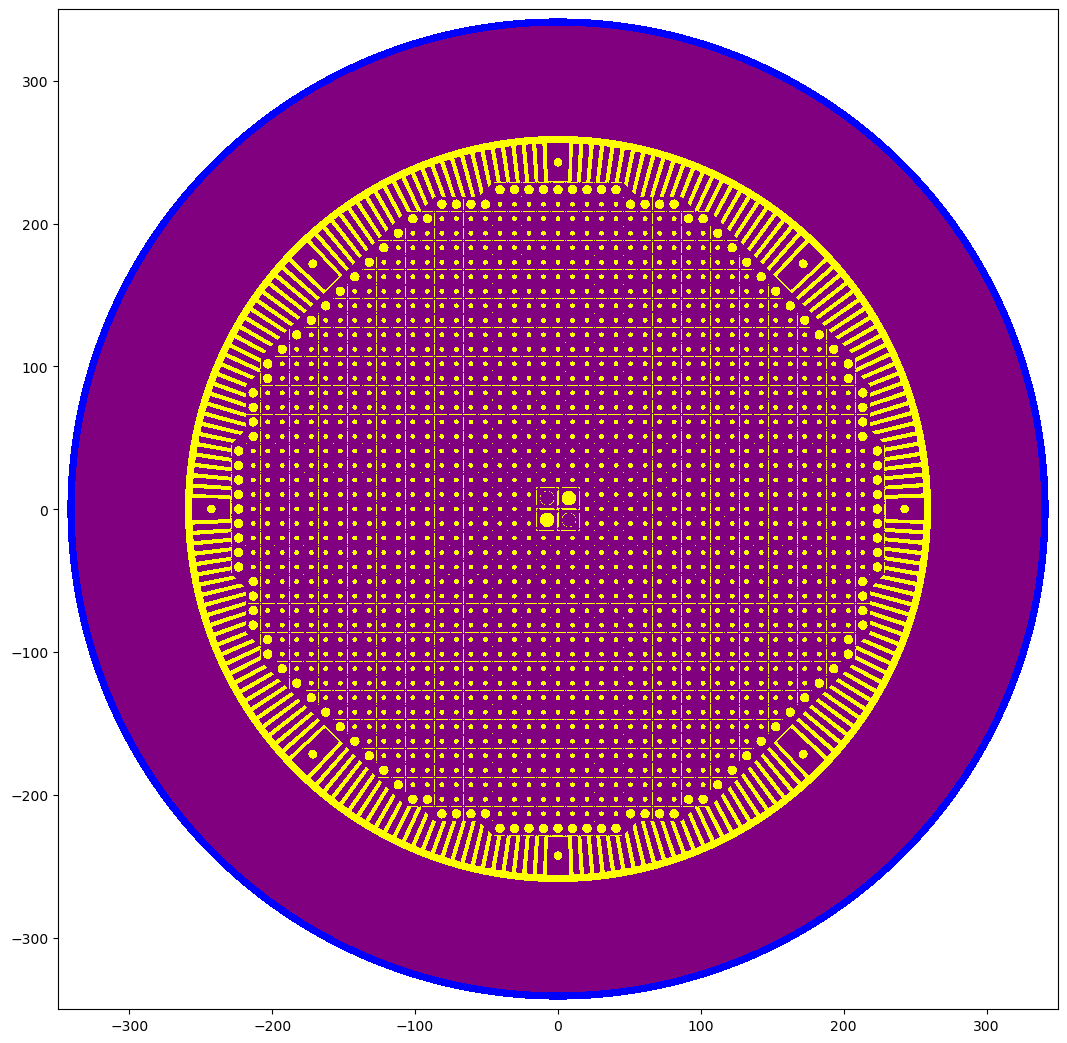

In [18]:
testuniverse.plot(width=(700,700),
        basis='xy',
        colors=colormap,
        origin=(0.,0.,200),
        color_by='material',
        pixels=(1000,1000))

In [ ]:
#testuniverse.plot(width=(700,650),
#        basis='xz',
#        colors=colormap,
#        origin=(0.,0.,220),
#        color_by='material',
#        pixels=(1000,1000))

In [21]:
geo = openmc.Geometry()
geo.root_universe = testuniverse
geo.remove_redundant_surfaces()
#geo.export_to_xml()

In [22]:
geo.get_all_cells()

OrderedDict([(541,
              Cell
              	ID             =	541
              	Name           =	cr_lattice
              	Fill           =	32
              	Region         =	(1525 -1526 1521 -1522 1523 -1524)
              	Rotation       =	None
              	Translation    =	None
              	Volume         =	None),
             (509,
              Cell
              	ID             =	509
              	Name           =	main_lattice
              	Fill           =	29
              	Region         =	(1525 -1526 ((-1527 1528 -1529 1530 1531 1532 -1533 -1534) | (-1535 1536 -1537 1538 1539 1540 -1541 -1542) | (-1543 1544 -1545 1546 1547 1548 -1549 -1550)) ~(1521 -1522 1523 -1524))
              	Rotation       =	None
              	Translation    =	None
              	Volume         =	None),
             (759,
              Cell
              	ID             =	759
              	Name           =	zone_iib
              	Fill           =	33
              	Region         =	(~((-

In [ ]:
plots = openmc.Plots()

plot = openmc.Plot(name='detail-zoneIA-IIA-lower1')
plot.origin=(215, 0, 10.0)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIA-main')
plot.origin=(215, 0, 23.0)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIIA-upper1')
plot.origin=(215, 0, 435)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIA-upper1')
plot.origin=(215, 0, 420)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIIA-upper2')
plot.origin=(215, 0, 437)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIA-upper2')
plot.origin=(215, 0, 439)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIIA-upper3')
plot.origin=(215, 0, 440)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIA-upper3')
plot.origin=(215, 0, 448)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='detail-zoneIIA-upper4')
plot.origin=(215, 0, 442)
plot.width=(40, 40)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIA-IIA-lower1')
plot.origin=(0.0, 0, 10.0)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIA-main')
plot.origin=(0, 0, 23.0)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIIA-upper1')
plot.origin=(0, 0, 435)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIA-upper1')
plot.origin=(0, 0, 420)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIIA-upper2')
plot.origin=(0, 0, 437)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIA-upper2')
plot.origin=(0, 0, 439)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIIA-upper3')
plot.origin=(0, 0, 440)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIA-upper3')
plot.origin=(0, 0, 448)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='full-zoneIIA-upper4')
plot.origin=(0, 0, 442)
plot.width=(600, 600)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xy'
plots.append(plot)

plot = openmc.Plot(name='core-xz-detail-upper')
plot.origin=(215, 0, 440)
plot.width=(100, 100)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xz'
plots.append(plot)

plot = openmc.Plot(name='full-core-xz')
plot.origin=(0, 0, 200)
plot.width=(700, 700)
plot.pixels=(1000,1000)
plot.color_by='material'
plot.colors=colormap
plot.basis='xz'
plots.append(plot)

plots.export_to_xml()